In [1]:
import sys

sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, corot, starmodels
from astronn.utils import inferences
from astronn.utils.metrics import *
from astronn import models

import tensorflow as tf
tf.autograph.set_verbosity(0)
from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Load stars datasets

In [2]:
# Read dataset with astroseismology info (dft, ac, hod, ...)
df_ds = deltascuti()
df_delta_scuti = df_ds.load(
    "../../astronn/data/deltascuti/preprocessed/*", batch_size=1
)

# Read csv with other phisical paramters (L, Teff, ..)
csv_delta_scuti = pd.read_csv("../data/deltascuti/binaries_obs.csv")
print(csv_delta_scuti)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              ID  Dnu_muHz          L  Teff  L.Ltot  parallax       mv  \
0     KIC3858884        29  21.520774  6606   0.470    1.7800   9.3360   
1     KIC4544587        74   6.475306  7750   0.332    1.3600  10.8470   
2    KIC10661783        39  29.304625  7764   0.937    1.9400   9.5630   
3       HD172189        19  29.942319  7750   0.702    2.2700   8.8850   
4   CID100866999

In [3]:
# Read dataset with astroseismology info (dft, ac, hod, ...)
bedding_stars = bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*", batch_size=1)

# Read csv with other phisical paramters (L, Teff, ..)
csv_bedding = pd.io.parsers.read_csv("../data/bedding/bedding_teff_logg_rad.csv", sep=",")
csv_bedding

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


,HD,Name,TIC,V,Teff,L,e.L.,rho,e.rho.,Dnu,...,e.vsini.,F0,logg,Teff_mast,e_logg,e_Teff_mast,stellar_radius,e_stellar_radius,ID,dnu_muhz
0,2280.0,NaN,281499618,9.13,7510.0,5.52,0.26,0.49,0.06,7.17,...,1.3,19.5741,4.39426,7575.00,0.079169,138.757,1.39528,0.042407,TESS2018234235059-S0002-0000000281499618-0121-...,82.986111
1,3622.0,NaN,43363194,7.77,7930.0,7.86,0.35,0.45,0.06,6.89,...,6.0,17.9829,4.33815,7779.00,0.080995,127.816,1.52225,0.043553,TESS2018263035959-S0003-0000000043363194-0123-...,79.745370
2,10779.0,NaN,229139161,8.78,7730.0,8.13,0.36,0.39,0.05,6.80,...,5.0,17.8840,4.31312,7862.00,0.079127,143.816,1.57905,0.044208,TESS2018234235059-S0002-0000000229139161-0121-...,78.703704
3,10961.0,NaN,231014033,9.39,7430.0,NaN,NaN,NaN,NaN,7.30,...,3.0,19.7100,4.30846,7600.00,0.080017,137.430,1.54452,0.052922,TESS2018263035959-S0003-0000000231014033-0123-...,84.490741
4,17341.0,NaN,122615966,9.32,7810.0,10.05,0.50,0.32,0.05,5.90,...,1.0,16.1070,4.24043,7850.00,0.078290,131.083,1.71688,0.046400,TESS2018263035959-S0003-0000000122615966-0123-...,68.287037
5,17693.0,NaN,122686610,7.80,7880.0,10.21,0.44,0.33,0.04,6.41,...,NaN,16.7301,4.24711,7940.00,0.074653,132.040,1.72004,0.047045,TESS2018263035959-S0003-0000000122686610-0123-...,74.189815
6,20203.0,NaN,274038922,8.85,7970.0,8.06,0.38,0.45,0.05,7.20,...,25.0,19.8720,4.39860,8144.00,0.073741,167.493,1.47477,0.046296,TESS2018292075959-S0004-0000000274038922-0124-...,83.333333
7,20232.0,NaN,159895674,6.88,8060.0,8.64,0.36,0.44,0.05,6.86,...,3.0,18.1104,4.33075,7963.00,0.072418,128.366,1.56787,0.043286,TESS2018263035959-S0003-0000000159895674-0123-...,79.398148
8,24572.0,NaN,242944780,9.45,7410.0,7.25,0.36,0.35,0.05,7.20,...,NaN,18.5760,4.32415,7928.00,0.087546,473.676,1.57199,0.052960,TESS2018319095959-S0005-0000000242944780-0125-...,83.333333
9,24975.0,NaN,44645679,7.24,7790.0,9.20,0.39,0.35,0.04,6.23,...,4.0,16.0734,4.23611,7693.00,0.077129,119.353,1.69752,0.047540,TESS2018319095959-S0005-0000000044645679-0125-...,72.106481


### Load pretrainned NN model

In [4]:
sepconv_mod = tf.keras.models.load_model(
    "/home/roberto/Projects/best_train/sepconvnn_tmp_dos_200/"
)
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 351, 10)           1010      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 342, 10)           1010      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 68, 10)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 68, 10)            40        
_________________________________________________________________
flatten (Flatten)            (None, 680)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               68100     
Total params: 70,160
Trainable params: 70,140
Non-trainable params: 20
___________________________________________________

## Results for 11 Binary DS Stars

In [5]:
inf = inferences()
df_results_delta_scuti = inf.get_processed_inferences(
    nn_model=sepconv_mod,
    df_stars=df_delta_scuti,
    take_number=11,
    csv_L=csv_delta_scuti,
    debug=False,
)
df_results_delta_scuti.id = df_results_delta_scuti.id.str.upper()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


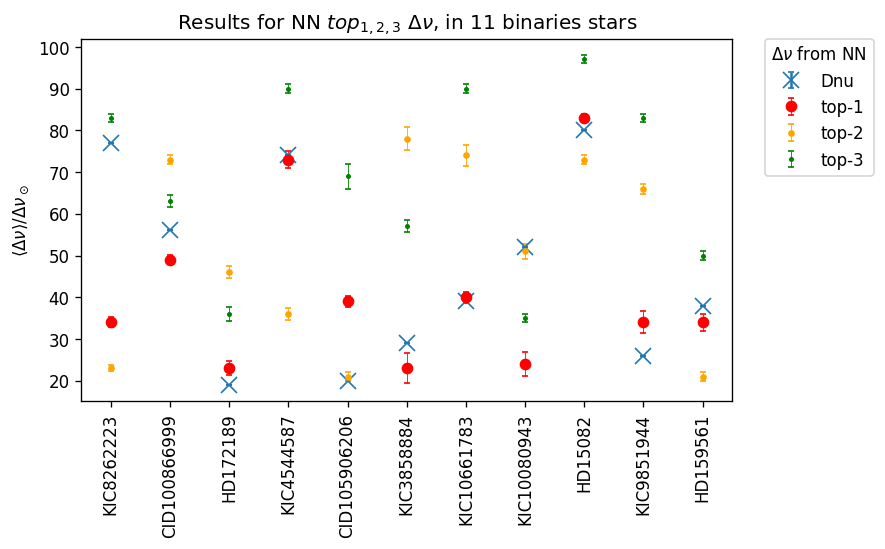

In [6]:
inf.plot_inferences(
    df_results_delta_scuti,
    plot_title="Results for NN $top_{1,2,3}$ $\Delta\\nu$, in 11 binaries stars",
    plot_size=(7, 4),
)

In [7]:
df_results_delta_scuti_merged = df_results_delta_scuti.merge(csv_delta_scuti , left_on="id", right_on="ID", how="left").drop('ID', 1)
df_results_delta_scuti_merged

,id,dnu-target,top1,e-top1,top2,e-top2,top3,e-top3,top4,e-top4,...,e-rho-top3,rho-top4,e-rho-top4,Dnu_muHz,L,Teff,L.Ltot,parallax,mv,rho-gh17
0,KIC8262223,77,34,1.161095,23,0.757434,83,1.005299,47,1.311323,...,0.188156,0.190451,0.060151,77,5.139949,9128,0.900,0.9832,12.8850,0.42300
1,CID100866999,56,49,1.044763,73,1.029168,63,1.455164,93,0.980278,...,0.108163,0.755931,0.236542,56,3.865000,7300,NaN,0.5654,15.0970,0.26000
2,HD172189,19,23,1.634795,46,1.377856,36,1.718467,89,1.336333,...,0.035312,0.691694,0.216514,19,29.942319,7750,0.702,2.2700,8.8850,0.02830
3,KIC4544587,74,73,1.929718,36,1.490254,90,1.030482,21,1.116072,...,0.221437,0.0374136,0.012076,74,6.475306,7750,0.332,1.3600,10.8470,0.41400
4,CID105906206,20,39,1.229034,21,1.178451,69,2.962202,52,1.141167,...,0.129821,0.2336,0.073637,20,9.396579,6750,0.940,0.9901,12.2620,0.02986
5,KIC3858884,29,23,3.613644,78,2.693781,57,1.409748,39,1.314869,...,0.088501,0.130646,0.041429,29,21.520774,6606,0.470,1.7800,9.3360,0.06570
6,KIC10661783,39,40,1.297765,74,2.518126,90,1.087349,58,1.154284,...,0.221437,0.291253,0.091640,39,29.304625,7764,0.937,1.9400,9.5630,0.12550
7,KIC10080943,52,24,2.963901,51,1.824679,35,0.926366,70,1.046125,...,0.033382,0.425838,0.133625,52,7.085301,7480,0.500,1.0600,11.7350,0.20500
8,HD15082,80,83,1.011470,73,1.015208,97,0.954947,46,1.144795,...,0.257471,0.182355,0.057618,80,6.140000,0,0.000,0.0000,0.0000,0.50700
9,KIC9851944,26,34,2.605530,66,1.189474,83,1.003733,54,1.387807,...,0.188156,0.252105,0.079417,26,60.062351,6902,0.500,0.4100,11.4770,0.05660


## Multiples of top1/top2 when top2 is requiered

In [8]:
select_closest_top = np.argmin(
    (
        np.power(
            np.asarray(df_results_delta_scuti_merged["dnu-target"])
            - np.asarray(df_results_delta_scuti_merged["top1"]),
            2,
        ),
        np.power(
            np.asarray(df_results_delta_scuti_merged["dnu-target"])
            - np.asarray(df_results_delta_scuti_merged["top2"]),
            2,
        ),
    ),
    axis=0,
)
tops = np.where(
    select_closest_top == 0,
    df_results_delta_scuti_merged["top1"],
    df_results_delta_scuti_merged["top2"],
)
# Show multiples
df_results_delta_scuti_merged.loc[select_closest_top == 1, ["id", "top1", "top2"]]

,id,top1,top2
4,CID105906206,39,21
7,KIC10080943,24,51


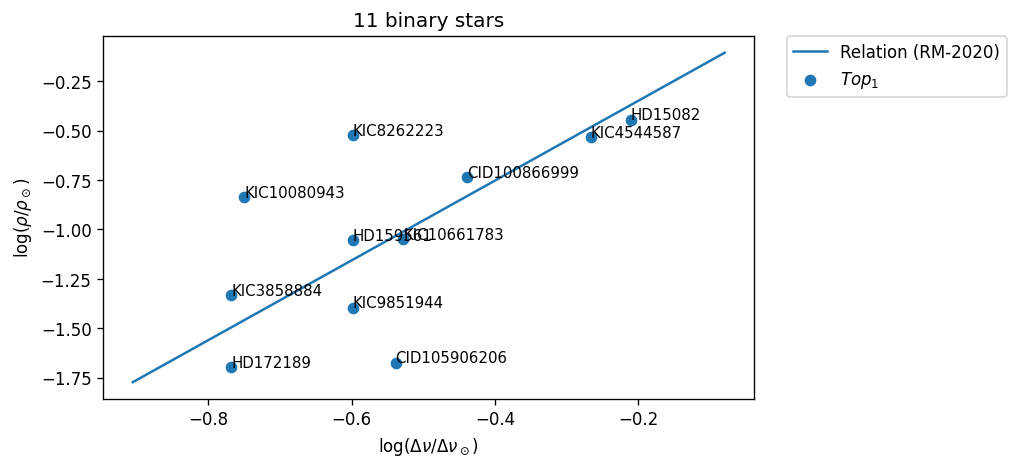

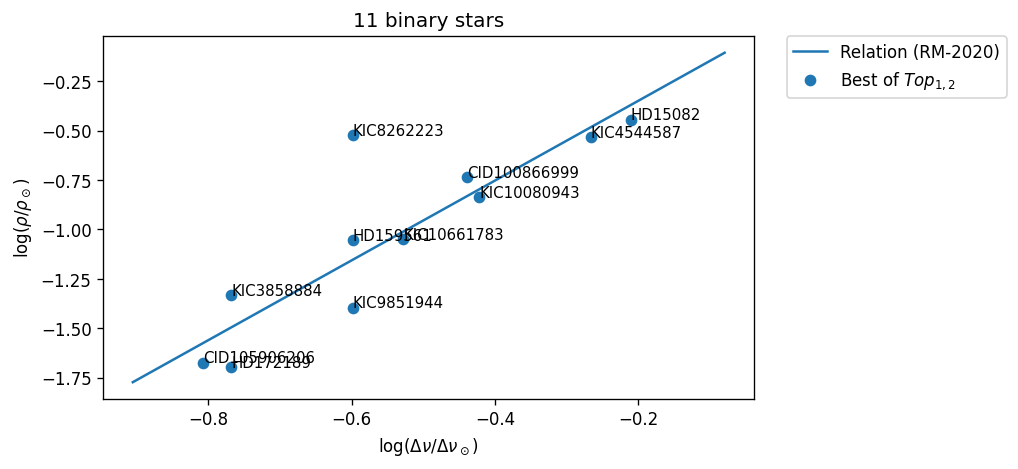

In [9]:
inferences.plot_relation_rodriguez(dnus=df_results_delta_scuti_merged["top1"].values.astype(float), 
                        rhos=df_results_delta_scuti_merged["rho-gh17"].values.astype(float),
                        points_ids=df_results_delta_scuti_merged["id"],
                        plot_title="11 binary stars",
                        points_label="$Top_1$")

inferences.plot_relation_rodriguez(dnus=tops.astype(float), 
                        rhos=df_results_delta_scuti_merged["rho-gh17"].values.astype(float),
                        points_ids=df_results_delta_scuti_merged["id"],
                        plot_title="11 binary stars",
                        points_label="Best of $Top_{1,2}$")

In [10]:
#df_binary_freqs = pd.read_csv(
#                "../../astronn/data/deltascuti/raw/CID105906206.lis",
#                #"../../astronn/data/bedding/raw/tess2018234235059-s0002-0000000229139161-0121-s_lc_det.dat",
#                sep="\s+",
#                header=None,
#                index_col=False,
#                names=["f", "signif", "a", "V4", "V5", "V6", "V7"],
#            )

## tess2018234235059-s0002-0000000229139161-0121-...	78	40	1.419688	71
#res = echelle(df_binary_freqs[["f"]].values / 0.0864, 20, saveplot = "N")

## Results for 57 Bedding stars


In [11]:
df_results_bedding = inf.get_processed_inferences(
    nn_model=sepconv_mod,
    df_stars=df_bedding,
    take_number=57,
    csv_L=csv_bedding,
    debug=False,
)
df_results_bedding

,id,dnu-target,top1,e-top1,top2,e-top2,top3,e-top3,top4,e-top4,...,rho-target,e-rho-target,rho-top1,e-rho-top1,rho-top2,e-rho-top2,rho-top3,e-rho-top3,rho-top4,e-rho-top4
0,tess2018234235059-s0002-0000000327996759-0121-...,69,42,1.149749,90,1.459779,71,2.637805,56,1.075839,...,0.413639,0.129821,0.151743,0.048039,0.707483,0.221437,0.438216,0.137485,0.271323,0.085418
1,tess2019006130736-s0007-0000000284348793-0131-...,81,34,1.552033,76,1.353517,63,1.136501,89,1.741907,...,0.571855,0.179152,0.0990225,0.031506,0.502794,0.157621,0.344203,0.108163,0.691694,0.216514
2,tess2018319095959-s0005-0000000242944780-0125-...,83,40,1.081245,77,1.093182,63,1.130061,51,1.112349,...,0.600737,0.188156,0.137502,0.043577,0.516247,0.161815,0.344203,0.108163,0.224615,0.070830
3,tess2018263035959-s0003-0000000231014033-0123-...,84,37,1.172332,82,1.823759,56,1.164646,21,1.444799,...,0.615447,0.192742,0.117466,0.037296,0.586206,0.183626,0.271323,0.085418,0.0374136,0.012076
4,tess2018319095959-s0005-0000000431695696-0125-...,84,40,1.282563,89,1.071572,55,1.946042,76,1.169338,...,0.615447,0.192742,0.137502,0.043577,0.691694,0.216514,0.261625,0.082390,0.502794,0.157621
5,tess2019058134432-s0009-0000000388351327-0139-...,82,73,2.227243,36,2.260625,59,1.567218,25,1.685216,...,0.586206,0.183626,0.463509,0.145372,0.111142,0.035312,0.301486,0.094834,0.053209,0.017078
6,tess2019032160000-s0008-0000000176400189-0136-...,76,32,1.466002,71,1.159129,52,1.154854,21,1.109137,...,0.502794,0.157621,0.0876091,0.027919,0.438216,0.137485,0.2336,0.073637,0.0374136,0.012076
7,tess2018349182459-s0006-0000000124381332-0126-...,86,41,1.758000,85,1.319659,56,1.326959,72,1.044920,...,0.645406,0.202083,0.144534,0.045781,0.630337,0.197384,0.271323,0.085418,0.450773,0.141401
8,tess2018319095959-s0005-0000000459942890-0125-...,82,38,2.072949,79,1.179070,58,1.808663,22,1.080464,...,0.586206,0.183626,0.123968,0.039335,0.543692,0.170372,0.291253,0.091640,0.0410998,0.013245
9,tess2018319095959-s0005-0000000044645679-0125-...,72,39,1.426456,61,1.718580,79,1.708922,28,2.176912,...,0.450773,0.141401,0.130646,0.041429,0.322487,0.101387,0.543692,0.170372,0.0668968,0.021398


In [12]:
df_results_bedding["TIC"] = df_results_bedding["id"].str.split("-").str[2].astype(int)
df_bedding_att = pd.io.parsers.read_csv("../data/bedding/bedding.csv", sep=",", index_col=0)
df_bedding_att = df_bedding_att[0:57]
df_bedding_att["TIC"] = df_bedding_att["TIC"].astype(int)


df_results_bedding_merged = df_results_bedding.merge(df_bedding_att, left_on="TIC", right_on="TIC", how="left")
df_results_bedding_merged

,id,dnu-target,top1,e-top1,top2,e-top2,top3,e-top3,top4,e-top4,...,Teff,L,e.L.,rho,e.rho.,Dnu,eps,vsini,e.vsini.,F0
0,tess2018234235059-s0002-0000000327996759-0121-...,69,42,1.149749,90,1.459779,71,2.637805,56,1.075839,...,NaN,NaN,NaN,NaN,NaN,6.04,1.82,261.0,40.0,17.0328
1,tess2019006130736-s0007-0000000284348793-0131-...,81,34,1.552033,76,1.353517,63,1.136501,89,1.741907,...,8200.0,9.22,0.45,0.44,0.06,7.08,1.65,50.0,2.0,18.7620
2,tess2018319095959-s0005-0000000242944780-0125-...,83,40,1.081245,77,1.093182,63,1.130061,51,1.112349,...,7410.0,7.25,0.36,0.35,0.05,7.20,1.58,NaN,NaN,18.5760
3,tess2018263035959-s0003-0000000231014033-0123-...,84,37,1.172332,82,1.823759,56,1.164646,21,1.444799,...,7430.0,NaN,NaN,NaN,NaN,7.30,1.70,33.0,3.0,19.7100
4,tess2018319095959-s0005-0000000431695696-0125-...,84,40,1.282563,89,1.071572,55,1.946042,76,1.169338,...,7961.0,8.85,0.57,0.40,0.05,7.26,1.61,NaN,NaN,18.9486
5,tess2019058134432-s0009-0000000388351327-0139-...,82,73,2.227243,36,2.260625,59,1.567218,25,1.685216,...,NaN,NaN,NaN,NaN,NaN,7.16,1.68,94.0,10.0,19.1888
6,tess2019032160000-s0008-0000000176400189-0136-...,76,32,1.466002,71,1.159129,52,1.154854,21,1.109137,...,NaN,NaN,NaN,NaN,NaN,6.64,1.58,24.0,3.0,17.1312
7,tess2018349182459-s0006-0000000124381332-0126-...,86,41,1.758000,85,1.319659,56,1.326959,72,1.044920,...,8270.0,10.02,0.53,0.42,0.05,7.45,1.61,178.0,37.0,19.4445
8,tess2018319095959-s0005-0000000459942890-0125-...,82,38,2.072949,79,1.179070,58,1.808663,22,1.080464,...,NaN,NaN,NaN,NaN,NaN,7.16,1.55,NaN,NaN,18.2580
9,tess2018319095959-s0005-0000000044645679-0125-...,72,39,1.426456,61,1.718580,79,1.708922,28,2.176912,...,7790.0,9.20,0.39,0.35,0.04,6.23,1.58,88.0,4.0,16.0734


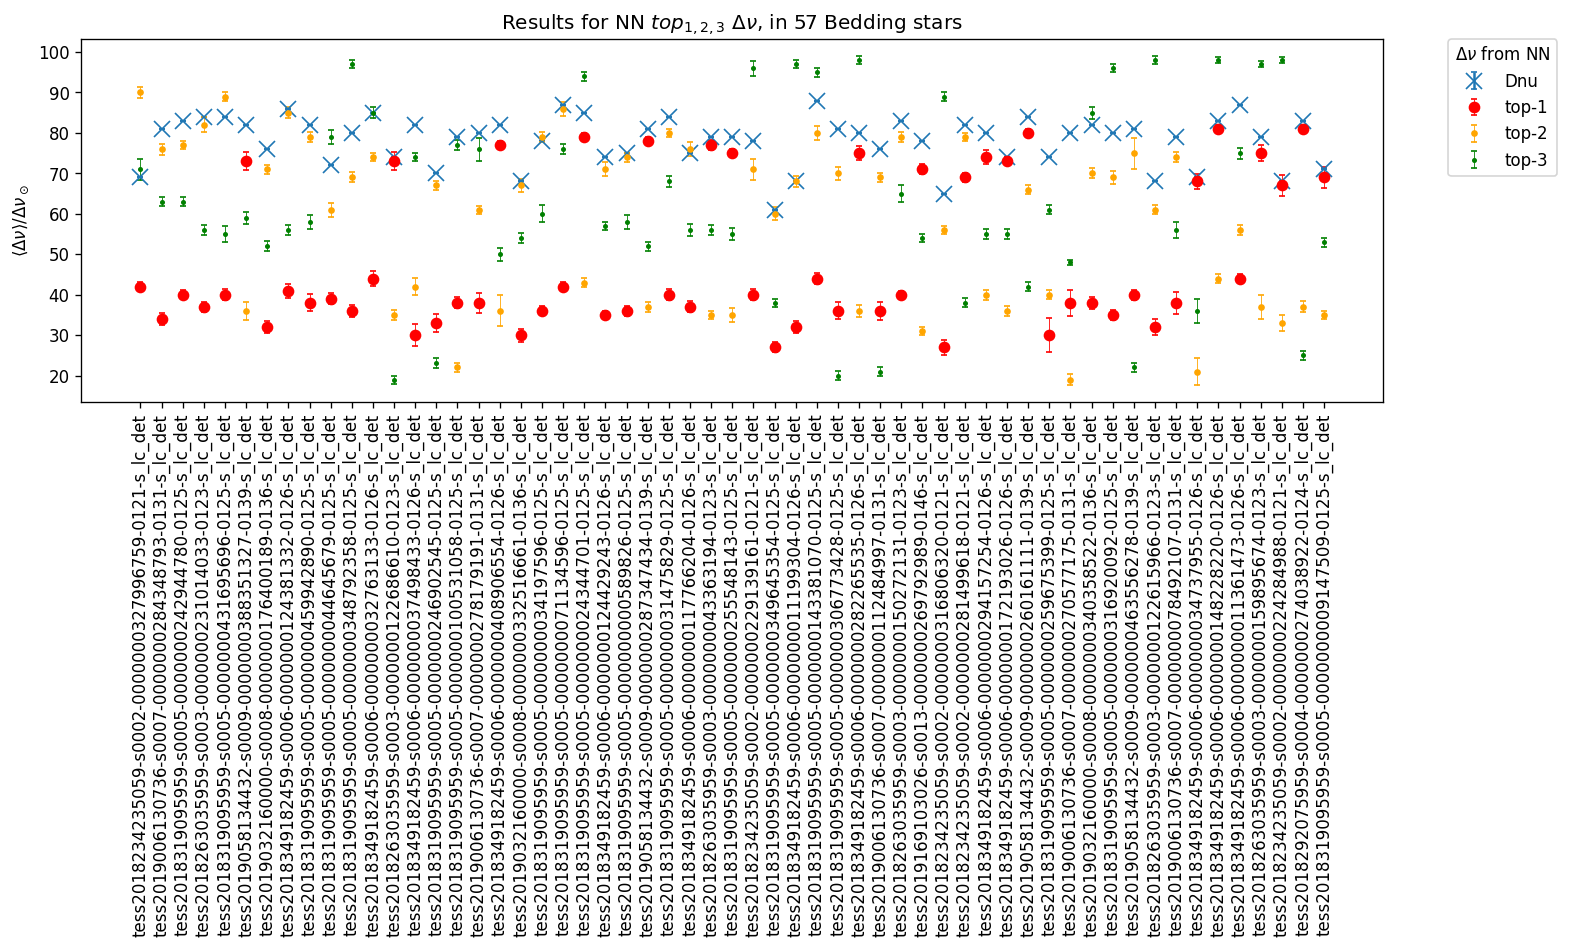

In [13]:
inf.plot_inferences(
    df_results_bedding_merged,
    plot_title="Results for NN $top_{1,2,3}$ $\Delta\\nu$, in 57 Bedding stars",
    plot_size=(14, 4),
)

In [14]:
select_closest_top = np.argmin(
    (
        np.power(
            np.asarray(df_results_bedding["dnu-target"])
            - np.asarray(df_results_bedding["top1"]),
            2,
        ),
        np.power(
            np.asarray(df_results_bedding["dnu-target"])
            - np.asarray(df_results_bedding["top2"]),
            2,
        ),
    ),
    axis=0,
)
tops = np.where(
    select_closest_top == 0, df_results_bedding["top1"], df_results_bedding["top2"]
)

#plt.hist(
#    df_results_bedding.loc[select_closest_top == 1, ["top1"]].values
#    / df_results_bedding.loc[select_closest_top == 1, ["top2"]].values,
#    bins=100,
#)
#plt.show()

array([90, 76, 77, 82, 89, 73, 71, 85, 79, 61, 69, 74, 73, 42, 67, 38, 61,
       77, 67, 79, 86, 79, 71, 74, 78, 80, 76, 77, 75, 71, 60, 68, 80, 70,
       75, 69, 79, 71, 56, 79, 74, 73, 80, 40, 38, 70, 69, 75, 61, 74, 68,
       81, 56, 75, 67, 81, 69], dtype=object)

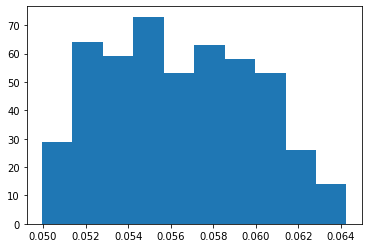

In [15]:
models = pd.read_csv("/home/roberto/Downloads/evolutionTracks_line_rho_roche/models_params.csv", 
                        header=None, 
                        names=["Teff", "Dnu", "L", "rho_roche"])

def get_avg_rho_roche(teff, l, e_teff=50, e_l=5):
    """
    """
    id_teff = models["Teff"].between(teff-e_teff, teff+e_teff, inclusive=True)
    id_l = models["L"].between(l-e_l, l+e_l, inclusive=True)
    return models[(id_teff & id_l)]["rho_roche"]

plt.hist(get_avg_rho_roche(8320.860521, 66))
plt.show()

In [16]:
df_results_bedding_merged["avg_rho_roche"] = df_results_bedding_merged[["Teff", "L"]].apply(lambda x: np.average(get_avg_rho_roche(x["Teff"], x["L"])), axis=1)
df_results_bedding_merged.head()

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,id,dnu-target,top1,e-top1,top2,e-top2,top3,e-top3,top4,e-top4,...,L,e.L.,rho,e.rho.,Dnu,eps,vsini,e.vsini.,F0,avg_rho_roche
0,tess2018234235059-s0002-0000000327996759-0121-...,69,42,1.149749,90,1.459779,71,2.637805,56,1.075839,...,NaN,NaN,NaN,NaN,6.04,1.82,261.0,40.0,17.0328,NaN
1,tess2019006130736-s0007-0000000284348793-0131-...,81,34,1.552033,76,1.353517,63,1.136501,89,1.741907,...,9.22,0.45,0.44,0.06,7.08,1.65,50.0,2.0,18.7620,0.454962
2,tess2018319095959-s0005-0000000242944780-0125-...,83,40,1.081245,77,1.093182,63,1.130061,51,1.112349,...,7.25,0.36,0.35,0.05,7.20,1.58,NaN,NaN,18.5760,0.391851
3,tess2018263035959-s0003-0000000231014033-0123-...,84,37,1.172332,82,1.823759,56,1.164646,21,1.444799,...,NaN,NaN,NaN,NaN,7.30,1.70,33.0,3.0,19.7100,NaN
4,tess2018319095959-s0005-0000000431695696-0125-...,84,40,1.282563,89,1.071572,55,1.946042,76,1.169338,...,8.85,0.57,0.40,0.05,7.26,1.61,NaN,NaN,18.9486,0.441865


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


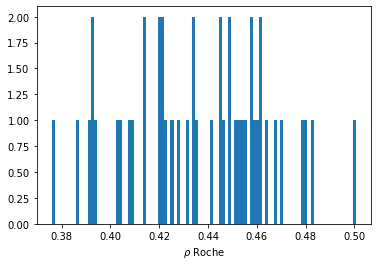

In [17]:
plt.hist(df_results_bedding_merged["avg_rho_roche"], bins=100)
plt.xlabel("$\\rho$ Roche")
plt.show()

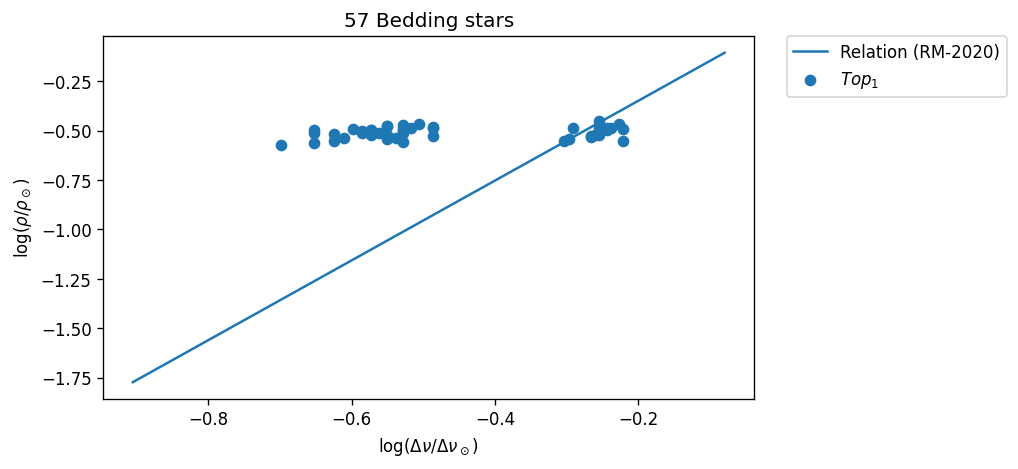

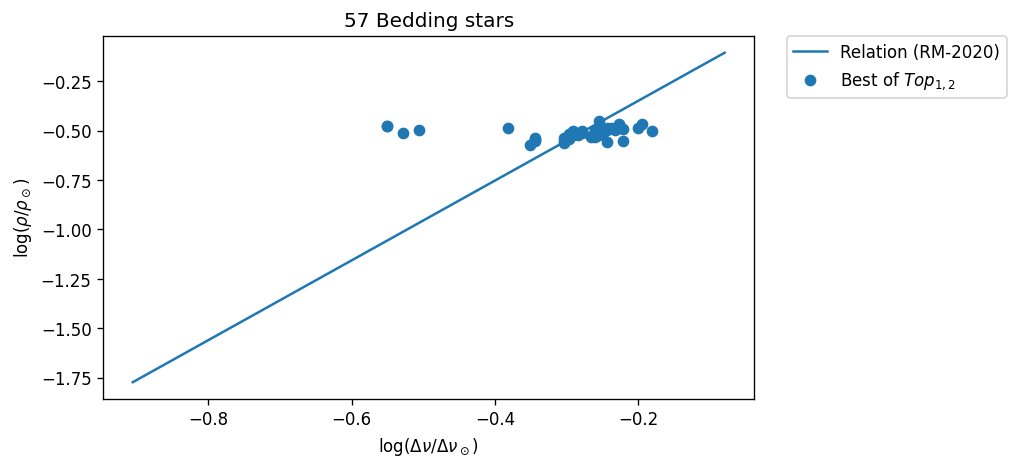

In [18]:
inferences.plot_relation_rodriguez(dnus=df_results_bedding_merged["top1"].values.astype(float), 
                        rhos=df_results_bedding_merged["avg_rho_roche"].values.astype(float),
                        points_ids=None,
                        plot_title="57 Bedding stars",
                        points_label="$Top_1$")

inferences.plot_relation_rodriguez(dnus=tops.astype(float), 
                        rhos=df_results_bedding_merged["avg_rho_roche"].values.astype(float),
                        points_ids=None,
                        plot_title="57 Bedding stars",
                        points_label="Best of $Top_{1,2}$")